# Environment

In [1]:
import os
from pprint import pprint
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode

import medmnist
from medmnist import INFO

import src.medmnist_dataset as md

In [2]:
# Get CWD
CWD = os.getcwd()

In [3]:
print(medmnist.__version__)

3.0.2


# Data

## Data Download

In [4]:
avaliable_datasets = ["pathmnist", "dermamnist", \
                    "octmnist", "pneumoniamnist", "breastmnist", \
                    "bloodmnist", "tissuemnist", "organamnist", \
                    "organcmnist", "organsmnist"] # "retinamnist", "chestmnist"]

In [5]:
for dataset_name in avaliable_datasets:
    
    info = INFO[dataset_name]
    print(f"-"*100)
    print(f"Dataset: {dataset_name}")
    print(f"Python: {info['python_class']}")
    print(f"Task: {info['task']}")
    print(f"Number of classes: {len(info['label'])}")
    print(f"Channels: {info['n_channels']}")
    print("Classes:")
    pprint(info['label'])

----------------------------------------------------------------------------------------------------
Dataset: pathmnist
Python: PathMNIST
Task: multi-class
Number of classes: 9
Channels: 3
Classes:
{'0': 'adipose',
 '1': 'background',
 '2': 'debris',
 '3': 'lymphocytes',
 '4': 'mucus',
 '5': 'smooth muscle',
 '6': 'normal colon mucosa',
 '7': 'cancer-associated stroma',
 '8': 'colorectal adenocarcinoma epithelium'}
----------------------------------------------------------------------------------------------------
Dataset: dermamnist
Python: DermaMNIST
Task: multi-class
Number of classes: 7
Channels: 3
Classes:
{'0': 'actinic keratoses and intraepithelial carcinoma',
 '1': 'basal cell carcinoma',
 '2': 'benign keratosis-like lesions',
 '3': 'dermatofibroma',
 '4': 'melanoma',
 '5': 'melanocytic nevi',
 '6': 'vascular lesions'}
----------------------------------------------------------------------------------------------------
Dataset: octmnist
Python: OCTMNIST
Task: multi-class
Number 

In [6]:
image_size = 28 # 28, 64, 128 or 256
datasets_path = os.path.join(CWD, "datasets", str(image_size))
os.makedirs(datasets_path, exist_ok=True)

md.download(avaliable_datasets, datasets_path, image_size)

File d:\AI\med-mnist\datasets\28\pathmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\dermamnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\octmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\pneumoniamnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\breastmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\bloodmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\tissuemnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\organamnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\organcmnist_28.npz already exists. Skipping download.
File d:\AI\med-mnist\datasets\28\organsmnist_28.npz already exists. Skipping download.


## Dataset Unification

In [7]:
organ_datasets = ["organamnist", "organcmnist", "organsmnist"] # These are the same - have the same classes

md.unify_data(
    organ_datasets,
    are_unique_classes  = False,
    image_size          = image_size,
    datasets_path       = datasets_path,
    save_path           = datasets_path,
    filename            = f"organs_{image_size}"
);

File d:\AI\med-mnist\datasets\28\organs_28.npz already exists.


In [8]:
new_avaliable_datasets = ["organs", "pathmnist", "dermamnist", "octmnist", "pneumoniamnist", \
                            "breastmnist", "bloodmnist", "tissuemnist"]

md.unify_data(
    new_avaliable_datasets,
    are_unique_classes  = True,
    image_size          = image_size,
    datasets_path       = datasets_path,
    save_path           = datasets_path,
    filename            = f"unified_{image_size}"
);

File d:\AI\med-mnist\datasets\28\unified_28.npz already exists.


## Dataset

In [9]:
transform = v2.Compose(
    [
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

# Training augmentations
augmentation = v2.Compose(
    [
        transform,
        v2.RandomHorizontalFlip(p=0.5),
        v2.Pad(round(image_size/10), padding_mode="reflect"),
        v2.RandomRotation(degrees=10, interpolation=InterpolationMode.BILINEAR),
        v2.CenterCrop(size=(image_size, image_size))
    ]
)

In [10]:
unified_dataset_path = os.path.join(datasets_path, f"unified_{image_size}.npz")

train_dataset = md.NPZDataset(unified_dataset_path, split="train", transform=augmentation)
validation_dataset = md.NPZDataset(unified_dataset_path, split="val", transform=transform)

## Data Loader

In [11]:
batch_size = 32
num_workers = 4

In [12]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size, 
    shuffle=True,
    num_workers=num_workers,
    prefetch_factor=10,
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers,
    prefetch_factor=10,
)

### Test Data Loader

Min: 0.0015344321727752686 Max: 1.0


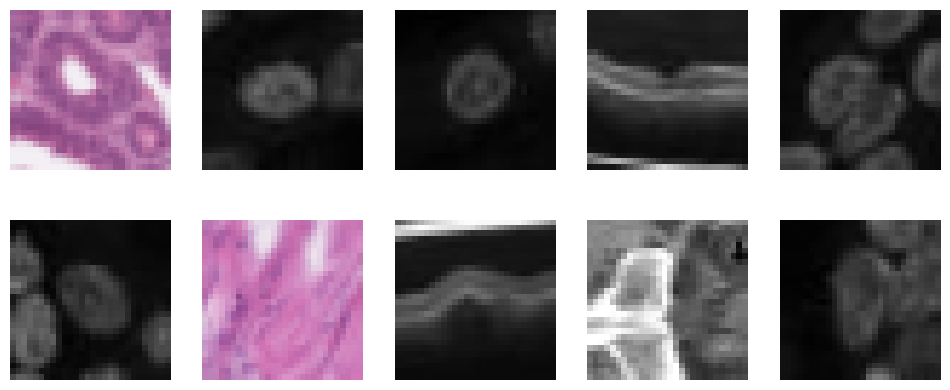

In [15]:
# Get one batch from train_loader
batch = next(iter(train_loader))
images, labels = batch  # Unpack batch

# # Denormalize for visualization
mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # Shape (C, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)

# Convert images back to [0, 1] range for visualization
images = images * std + mean  
images = torch.clamp(images, 0, 1)  # Ensure values stay in range

# Plot some images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))  # Grid 2x5
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) → (H, W, C)
    ax.imshow(img)
    ax.axis("off")

plt.show()